# Assignment 3
## Question 2: Preconditioned iterative solvers

Consider the Laplace problem $$ -\Delta u = 0 $$ on the domain $ \Omega := \Omega_1\cup\Omega_2 $ with $ \Omega_1 := [-1,0]\times[-1,1] $ and $ \Omega_2 := [-1,1]\times[0,1] $ with nonzero boundary conditions $ u = f $ on the boundary of $ \Omega $ which is a classical L-shaped domain. The nonzero boundary conditions function is $$ f(x,y) = \frac12log((x-x_0)^2 + (y-y_0)^2) $$ with point $ (x_0, y_0) $ chosen outside the domain $ \Omega $. This function satisfies $ \Delta u=0 $. So when I choose funtion $ f(x, y) $ as boundary conditions, I reproduce it in the interior of the domain $ \Omega $.

In [56]:
# Import libraries

import numpy as np

from scipy.sparse import coo_matrix
from scipy.sparse.linalg import LinearOperator, cg, spilu

%matplotlib inline
from matplotlib import pyplot as plt

## Sparse CSR Matrix $A$


Consider matrix $ A $ as sparse CSR matrix format, I write a routine that for a given grid size parameter $ h $ generates a $ 5 $ point stencil discretisation of this domain and for a given boundary function $$ f(x,y) = \frac12log((x-x_0)^2 + (y-y_0)^2) $$ generates the matrix A and right-hand side $ b $ of the discrete linear system $ Ax = b $ explicitly.


Firstly, input parameter $ h $ which is the grid spacing, then return $ n $ (the number of points on the grid in interval $ [0, 1] $) and matrix $ A $ in the end. I create a COO matrix A which is suitable for the generation of sparse CSR matrices. Then I set the main diagonal of matrix $ A $ be 1 to let matrix $ A $ be an identity matrix $ A $.


Secondly, I write a routine to populate the interior grid points of the 5-point stencil operator. Loop over each row in matrix $ A $ every time, just like the conclusion we found in Question 1, data transmit row by row. $ i $ means the index of the i-th element, so its domain is $ [0, 4n^2] $. Set j be the quotient of $ \frac{(i + 2n)}{2n} $ which means the column number of the elements.Since each row we have $ 2n $ points(or columns).


I do this in two blocks. The first one is the interior block spanning the top left and top right areas of the L-shaped. The second one is the single lower right area of the L-shaped. 


In the first block, the domain is $ [0,2n-1]\times[0,n-1] $ and we have $ 2n $ columns and $ n $ rows. Except the boundaries, the domain is $ [1,2n-2]\times[1,n-2] $ and we have $ 2n-2 $ columns and $ n-2 $ rows. I put the first block into two areas. The boundaries of area 1 is the left boundary(column 0) and the top boundary(row $0$). The boundaries of area 2 is the top boundary(row $0$), the right boundary(column $2 n - 1$) and the bottom boundary(row $n - 1$). Add $ 3 $ to the elements on the main diagonal, we call them centre points. and the top, left, right and bottom points which are next to the centre points with distance $1$ are all $-1$. That means the matrix $A$ looks like this: the elements on the main diagonal are $4$, the elements on left and right diagonals next to main diagonal with distance $ 1 $ are $ -1 $. The elements on left and right diagonals next to main diagonal with distance $ n $ are $ -1 $. 
    
In the second block, the domain is $ [0,n-1]\times[n-1, 2n-1] $ and we have $ n $ columns and $ n $ rows. Except the boundaries, the domain is $ [1,n-2]\times[n-1,2n-2] $ and we have $ n-2 $ columns and $ n-1 $ rows. I put the second block as areas 3. The boundaries of area 3 is the left boundary(column $0$), the bottom boundary( row $2n-1$) and the right boundary(colum $n-1$). The value of elements are similar with the elements in the ifrst block.
    
I'll set the elements in the bottom right area be nan when visualise.

Lastly, return $n$ and matrix $A$.
       

In [57]:
def A_mat(h):
    """
    The function returns a tuple containing n, the matrix A in CSR format and the vector b.
    
    """
    
    # Parameter h is the grid spacing.
    # n is the number of points on the grid in interval [0, 1].
    # The size of the L-shaped domain is (2 * n) * (2 * n).
    n = np.int32(1.0 / h + 1)                                 
    
    # Create an empty COO matrix A.
    A = coo_matrix(((2 * n) * (2 * n), (2 * n) * (2 * n) ), dtype = np.float32)     
    A.setdiag(1.0)                                # Create an Identity matrix A.
    


    # Now, populate the interior grid points of the 5-point stencil operator. We need to do this
    # in two blocks. The first one is the interior block spanning the top left and top right areas
    # of the L-shaped. The second one is the single lower left area of the L-shaped.
    
    
    for i in range((2 * n) * (2 * n)):
        
        j = (i + 2 * n) % (2 * n)  # It means the i-th point on the grid with column j.
        
        # Area 1 and 2 except the boundaries:
        # boundaries of area 1: left(column 0) and top(row 0);
        # boundaries of area 2: top(row 0), right(column ((2 * n) - 1)) and bottom(row (n - 1)).
    
        # Caculate inner area from row 1 to row (n - 2).
        if (i > (2 * n) and i < (2 * n) * (n - 1)):
            
            # Caculate inner area from column 1 to column ((2 * n) - 2).
            if (j > 0 and j < (2 * n) - 1):

                # Centre point.
                A.row = np.append(A.row, i)
                A.col = np.append(A.col, i)
                A.data = np.append(A.data, 3.0)    
  
                # Top point.
                A.row = np.append(A.row, i)
                A.col = np.append(A.col, i - (2 * n))
                A.data = np.append(A.data, -1.0)       
                
                # Left point.
                A.row = np.append(A.row, i)
                A.col = np.append(A.col, i - 1)
                A.data = np.append(A.data, -1.0)       
  
                # Right point.
                A.row = np.append(A.row, i)
                A.col = np.append(A.col, i + 1)
                A.data = np.append(A.data, -1.0)       

                # Bottom point.
                A.row = np.append(A.row, i)
                A.col = np.append(A.col, i + (2 * n))
                A.data = np.append(A.data, -1.0)

                
        # Area 3 except the boundaries:
        # left(column 0), bottom(row ((2 * n) - 1)) and right(column (n - 1)).
        
        # Caculate inner area from row (n - 1) to row ((2 * n) - 2).
        if (i > (2 * n) * (n - 1) and i < (2 * n) * (2 * n - 1)):
            
            # Caculate inner area from column 1 to column (n - 2).
            if (j > 0 and j < n - 1):
                
                # Centre point.
                A.row = np.append(A.row, i)
                A.col = np.append(A.col, i)
                A.data = np.append(A.data, 3.0)        
                
                # Top point.
                A.row = np.append(A.row, i)
                A.col = np.append(A.col, i - (2 * n))
                A.data = np.append(A.data, -1.0)       

                # Left point.
                A.row = np.append(A.row, i)
                A.col = np.append(A.col, i - 1)
                A.data = np.append(A.data, -1.0)   
                
                # Right point.
                A.row = np.append(A.row, i)
                A.col = np.append(A.col, i + 1)
                A.data = np.append(A.data, -1.0)       

                # Bottom point.
                A.row = np.append(A.row, i)
                A.col = np.append(A.col, i + (2 * n))
                A.data = np.append(A.data, -1.0)
            
    # Return n and the matrix A in CSR format.
    return n, A.tocsr()

## Boundary Conditions Vector $b$

Vector $b$ is contains the boundary conditions. And it has nonzero boundary conditions $ u = f $ on the boundary of $ \Omega $ which is a classical L-shaped domain. The nonzero boundary conditions function is $$ f(x,y) = \frac12log((x-x_0)^2 + (y-y_0)^2) $$ with point $ (x_0, y_0) $ chosen outside the domain $ \Omega $. This function satisfies $ \Delta u=0 $. So when I choose funtion $ f(x, y) $ as boundary conditions, I reproduce it in the interior of the domain $ \Omega $. And I choose point $ (x_0, y_0) $ as a point in the bottom right area.

In [58]:
def b_vec(h):
    """
    Determine vector b setting the boundary conditions f.
    The function f(x, y) = 0.5 * log((x - x0) ** 2 + (y - y0) ** 2)
    with a point (x0, y0) chosen outside the domain.
    
    """
    
    b = np.zeros((2 * n, 2 * n), dtype = np.float32)    
    x0 = 2 * n
    y0 = 2 * n
    
    for x in range(2 * n):
        for y in range(2 * n):
            f = 0.5 * np.log((x - x0) ** 2 + (y - y0) ** 2)
            b[x, y] = f
            
    b[1 : n - 1, 1 : 2 * n - 1] = 0
    b[n -1 : 2 * n - 1, 1 : n - 1] = 0

            
    # Return b as a vector.
    return b.flatten()

## Visualise Preconditioned Iteration

Set the elements in the bottom right area be nan when plot.

In [59]:
def plot_soln(x):
    """
    Declare a function to plot the solution.
    """
    
    # Area 4 is empty.
    empty = np.ones((2 * n, 2 * n), dtype = np.float32)
    empty[n : (2 * n), n : (2 * n)] = np.nan
    
    plt.figure(figsize = (10, 8))
    plt.imshow(x.reshape(2 * n, 2 * n) + empty, extent=[0, 1, 0, 1])
    plt.title("Solution x in L-shaped")
    plt.axis('Off')
    plt.colorbar()
    

### Test Visualisation of Preconditioned Iteration

Solve the associated linear system directly with CG

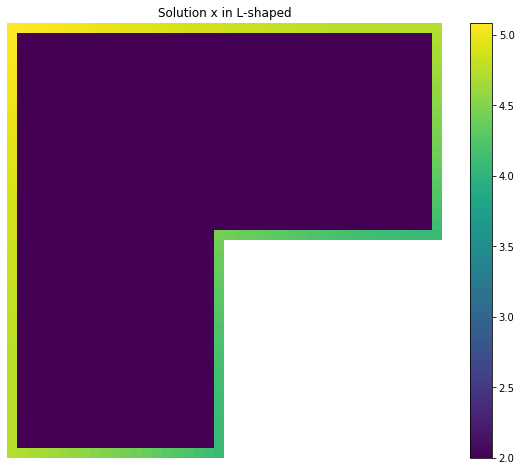

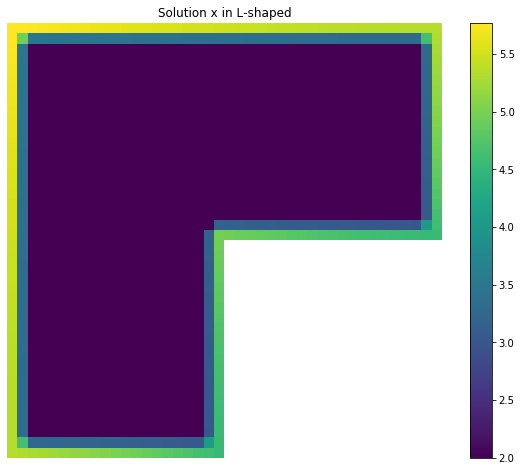

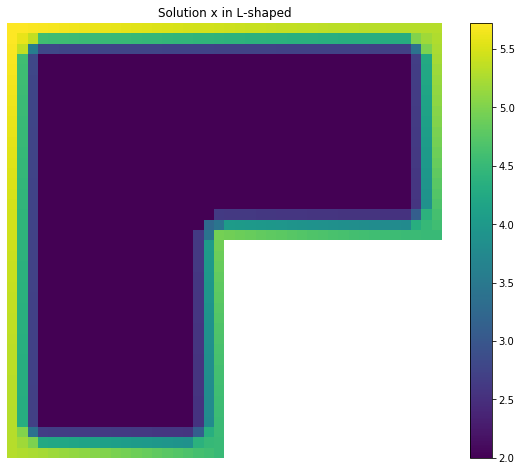

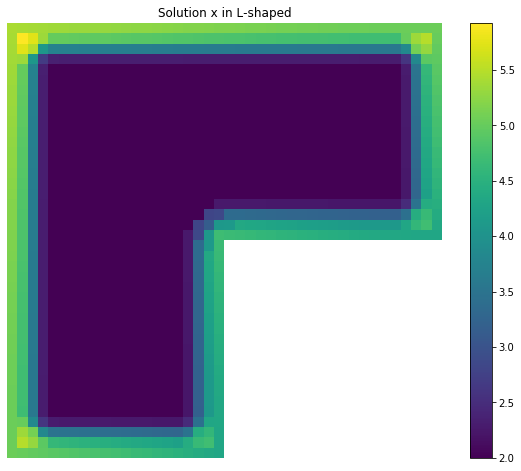

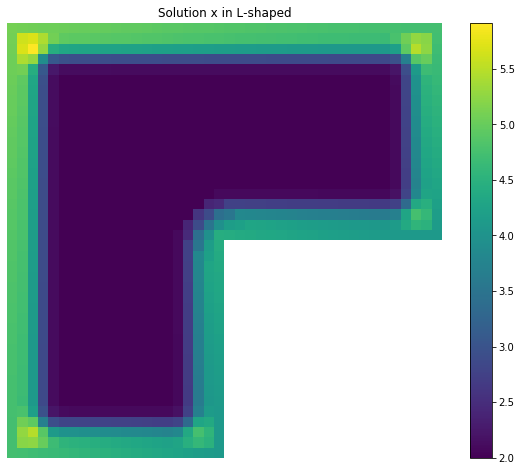

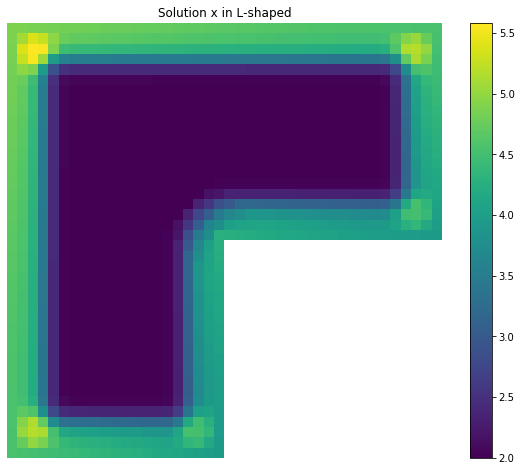

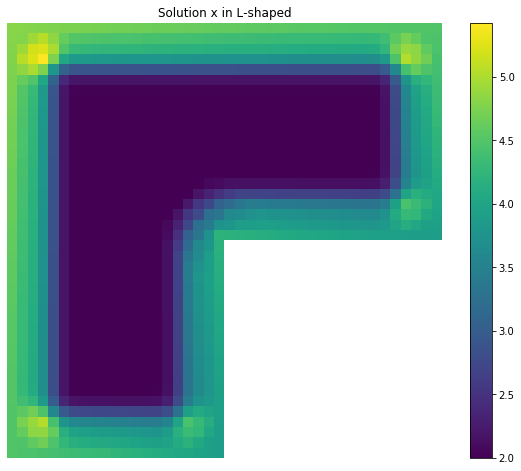

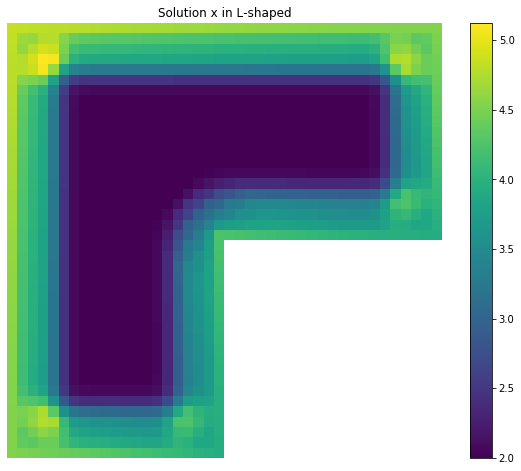

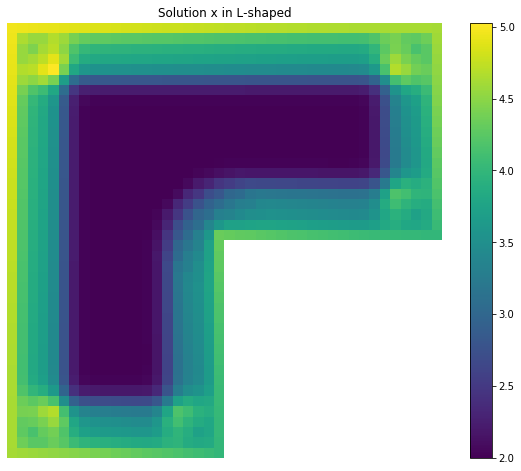

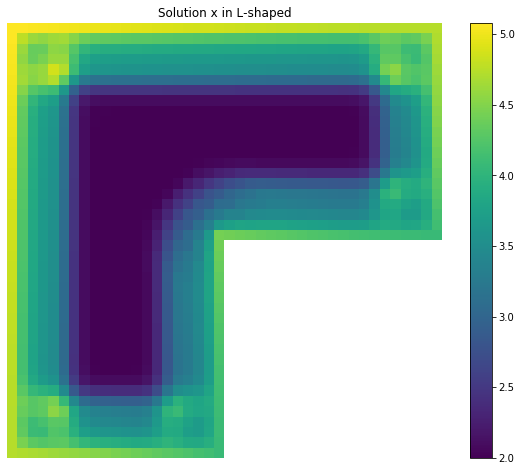

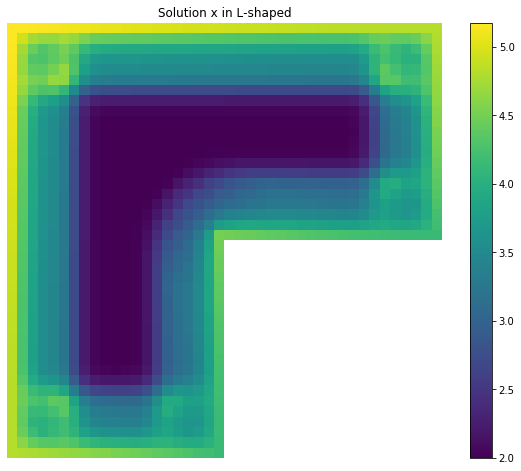

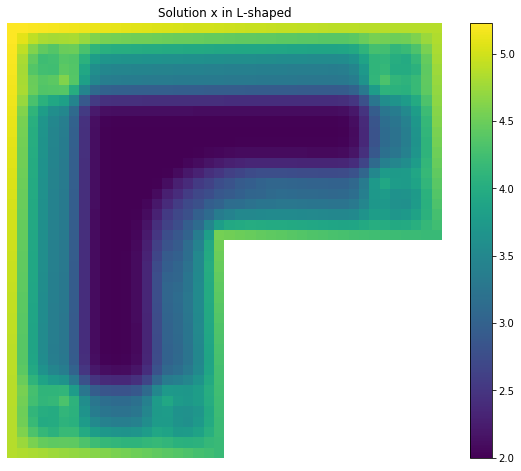

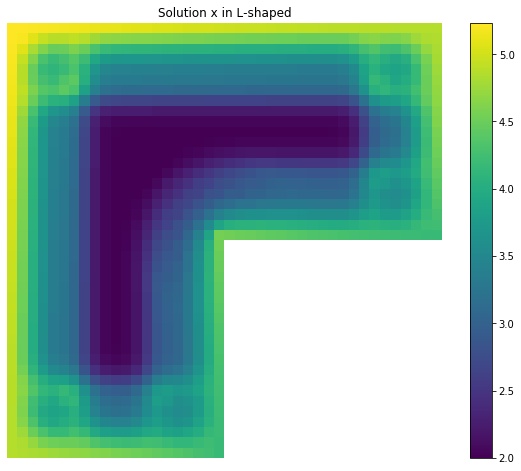

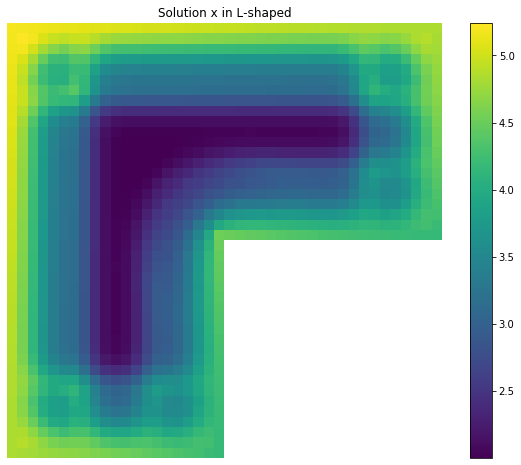

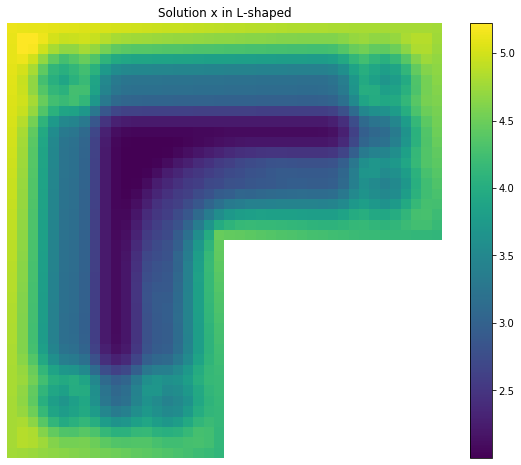

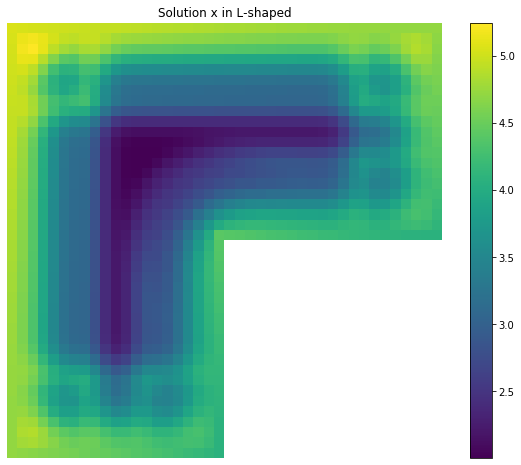

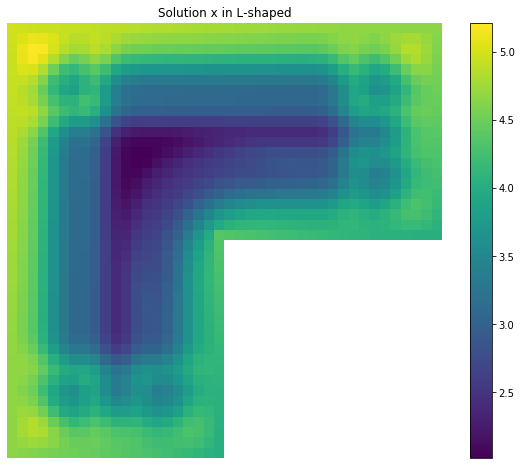

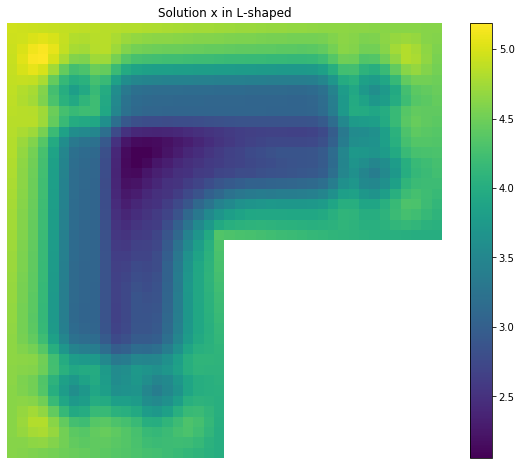

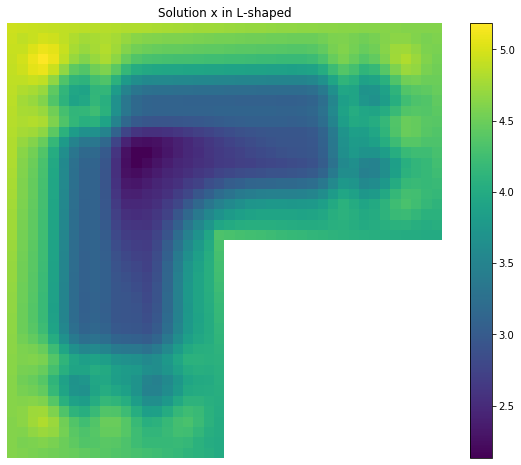

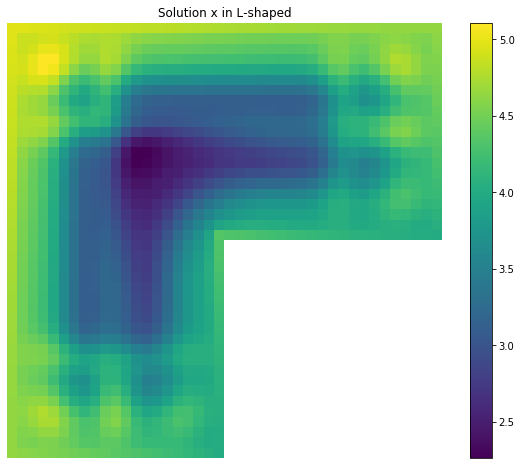

In [60]:
# Use the SciPy cg iterative solver to solve the system and generate iteration plots.
h = 0.05
maxIter = 20

n, A = A_mat(h)
b = b_vec(h)
u = np.full(((2 * n) * (2 * n)), 1, dtype = np.float32)    

x, info = cg(A, b, x0 = u, callback = plot_soln, maxiter = maxIter)

### Visualise Preconditioned Iteration

Solve the associated linear system directly with CG.

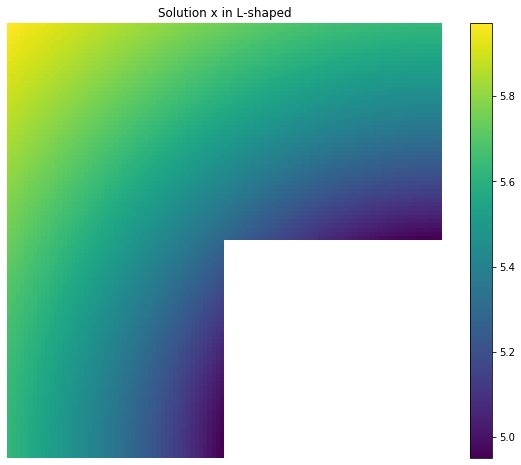

In [61]:
# Use the SciPy cg iterative solver to solve the system.
h = 0.02

n, A = A_mat(h)
b = b_vec(h)
u = np.full(((2 * n) * (2 * n)), 1, dtype = np.float32)    

x, info = cg(A, b, x0 = u)

plot_soln(x)

As can be seen the plot above, the solution has converged to the interior points of the function defined on the domain boundaries.

## Check

### Plot Matrix $A$ and Plot Boundary Conditions Vector $b$
Note that the A matrix is not uniform in the operation it applies, it is diagonal and symmetric as required by the SciPy cg iterative solver.

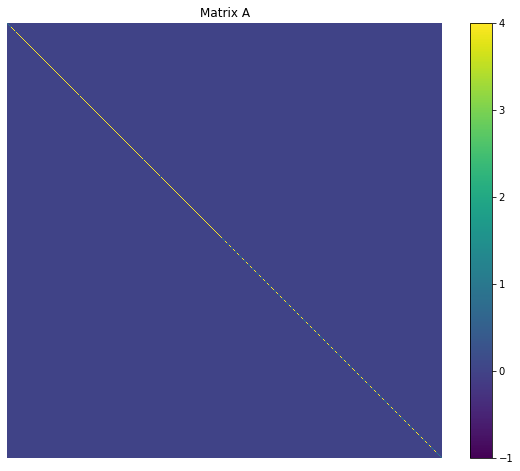

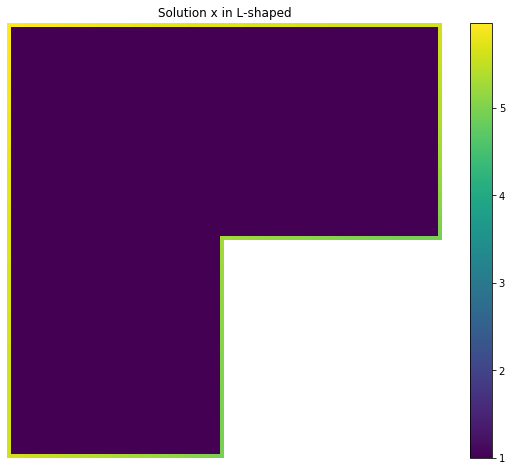

In [62]:
# Plot matrix A.

plt.figure(figsize = (10, 8))
plt.imshow(A.todense(), extent=[0, 1, 0, 1])
plt.title("Matrix A")
plt.colorbar()
plt.axis('Off')
plt.show()

# Plot vector b.

plot_soln(b.reshape(2 * n, 2 * n))

### Plot $b$ and $Ax$ to Check the Solution

They look same as each other.

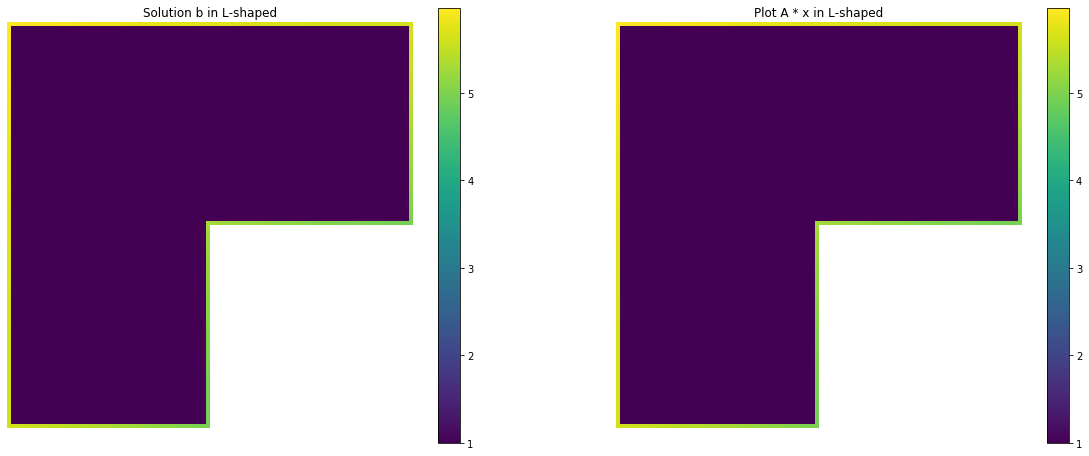

In [63]:
def plot(b, Ax):
    
    # Area 4 is empty.
    empty = np.ones((2 * n, 2 * n), dtype = np.float32)
    empty[n : (2 * n), n : (2 * n)] = np.nan
    
    plt.figure(figsize = (20, 8))
    
    # Plot vector b in L-shaped.
    plt.subplot(1, 2, 1)
    plt.imshow(b.reshape(2 * n, 2 * n) + empty, extent=[0, 1, 0, 1])
    plt.title("Solution b in L-shaped")
    plt.axis('Off')
    plt.colorbar()
    
    # Plot A * x.
    plt.subplot(1, 2, 2)
    plt.imshow(Ax.reshape(2 * n, 2 * n) + empty, extent=[0, 1, 0, 1])
    plt.title("Plot A * x in L-shaped")
    plt.axis('Off')
    plt.colorbar()
    
    plt.show()
    
plot(b.reshape((2 * n), (2 * n)), A * x)

## Convergence of CG 

We study the convergence of CG as increasing the number of discretisation points, that is to say we should decrease the values of parameter $ h $ which is the distence of each grids, since $ h = \frac{1}{n - 1}1\ $. As increasing the number of discretisation points, the values of h decrease. We test four different values of h which are $ H = 0.1, 0.05, 0.04, 0.02 $, and they all can get n as integer values.

We calculate each relative residual $$ res = \frac {\left|\left|b -Ax\right|\right|_2} {\left|\left|b\right|\right|_2}$$ by using semilogy plot in Matplotlib.

From the convergence curves, we found that as increasing the number of discretisation points (through decreasing parameter $ h $), the relative residual decrease faster. The reason is that when we decrease the value of parameter $ h $, as the smaller distence we have, the information transmit faster.

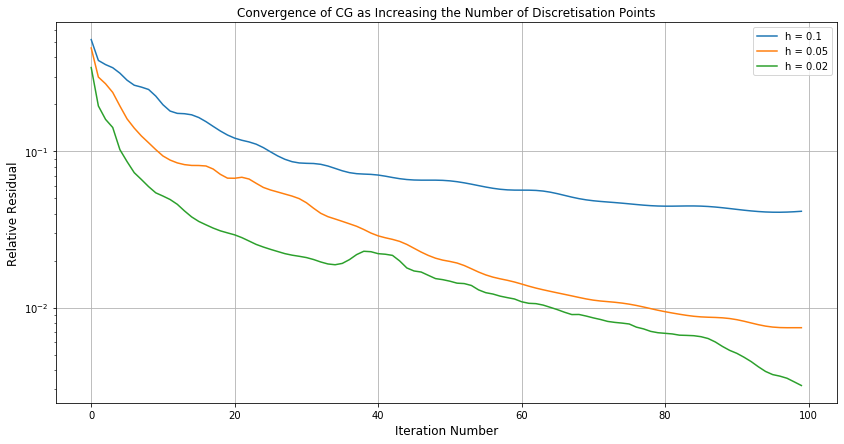

In [64]:
# Convergence of CG as increasing the number of discretisation points.

maxIter = 100                           # Maximum value of iteration.

H = [0.1, 0.05, 0.02]             # Four different values of h.
rel_res = list([[], [], []])        # Relative residual.

for i, h in enumerate(H):

    n, A = A_mat(h)
    b = b_vec(h)
    
    def rel_residual(x):
        rel_res[i].append(np.linalg.norm(b - A * x) / np.linalg.norm(b))

    u = np.full(((2 * n) * (2 * n)), 1.0, dtype = np.float32)    

    x, info = cg(A, b, x0 = u, callback = rel_residual, maxiter = maxIter)


# Plot the relative residuals.

fig = plt.figure(figsize = (14, 7))

plt.semilogy(range(maxIter), rel_res[0], label="h = 0.1")
plt.semilogy(range(maxIter), rel_res[1], label="h = 0.05")
#plt.semilogy(range(maxIter), rel_res[2], label="h = 0.04")
plt.semilogy(range(maxIter), rel_res[2], label="h = 0.02")

plt.xlabel("Iteration Number", fontsize = 12)
plt.ylabel("Relative Residual", fontsize = 12)

plt.title("Convergence of CG as Increasing the Number of Discretisation Points", fontsize = 12)

plt.legend(loc = 1)
plt.grid()
plt.show()

As can be seen from the plot above, as the grid size 'h' is reduced (increased discretisation points), the relative residual reduces faster. This is to be expected since a reduced value of 'h' will premit the spreading off data across the grid more quickly.

## Incomplete LU Factorisation


An often effective preconditioner is given by ILU, the Incomplete LU factorisation. The idea that is that an LU decomposition is performed,
but too much fill in of nonzero elements through Gaussian elimination
is avoided by setting a drop tolerance of the size of values to be discarded.
This leads to an pproximation of Gaussian elimination that only needs
little more storage than the original matrix. Scipy has in its sparse linear
algebra module an spilu routine that implements this. 

We use the ILU of
the system matrix $ A $ as an approximate preconditioner and investigate
for different values of the drop factors how the convergence of CG changes.

Take different values of drop tolerances($ 0.15, 0.26, 0.45 $) and investigate them effect on CG convergence. We set $ h = 0.05 $. Drop tolerance $ {0} \le {tol} \le {1} $ for an incomplete LU decomposition which stated by scipy.sparse.linalg.spilu documentation. (default: $ 10^{-4} $)

Investigate the rules through the plot, when drop tolerances increase, the relative residuals decrease faster. When $ tol = 0.15 $, the changes of relative residualcan be ignore, since they are too marginal. When $ tol = 0.26 $ and $ tol = 0.45 $ the changes are distinct. And these two curves drop below the $ 10^{-2} $ when their iteration number achieve at $ 60 $. Additionally, we found that when the number of iteration is larger than $ 60 $, the orange and green curves decrease slower than before. 

Therefore, the larger drop tolerate to be, the more faster relative residuals decrease and the larger effective to CG convegence.

/Users/shuaiyu/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:372: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


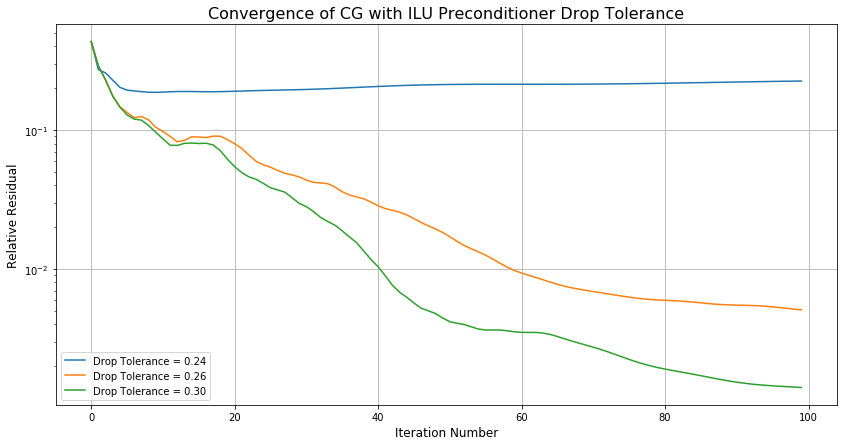

In [65]:
# An often effective preconditioner is given by ILU, 
# the incomplete LU factorisation.

h = 0.05                            # Grid parameter h.
maxIter = 100                       # Maximum value of iteration.
DT = [0.24, 0.26, 0.30]             # Drop tolerance.
rel_res = list([[], [], []])        # Relative residual.

for i, drop_tolerance in enumerate(DT):

    n, A = A_mat(h)
    b = b_vec(h)
       
    def rel_residual(x):
        rel_res[i].append(np.linalg.norm(b - A * x) / np.linalg.norm(b))

    u = np.full(((2 * n) * (2 * n)), 1.0, dtype = np.float32)
    
    P = spilu(A, drop_tol = drop_tolerance, fill_factor = 1.0)
    Mx = lambda x: P.solve(x)
    M_x = LinearOperator(((2 * n) * (2 * n), (2 * n) * (2 * n)), Mx)
    
    x, info = cg(A, b, x0 = u, callback = rel_residual, maxiter = maxIter, M = M_x)


# Plot relative residuals.

fig = plt.figure(figsize = (14, 7))

plt.semilogy(range(maxIter), rel_res[0], label = "Drop Tolerance = 0.24")
plt.semilogy(range(maxIter), rel_res[1], label = "Drop Tolerance = 0.26")
plt.semilogy(range(maxIter), rel_res[2], label = "Drop Tolerance = 0.30")

plt.xlabel("Iteration Number", fontsize = 12)
plt.ylabel("Relative Residual", fontsize = 12)
plt.title("Convergence of CG with ILU Preconditioner Drop Tolerance", fontsize = 16)
plt.legend(loc = 3)
plt.grid()
plt.show()


Various values of drop tolerances were investigated to determine the effect on CG convergence for a fixed 'h' of 0.05.

From the previous investigation into the effect of the number of discretisation points on CG convergence, it can be determined that the relative residual dropped to 10e-2 after approximately 80 iterations (for 'h' = 0.05). From the plot above it can be determined that the relative residual dropped to the same value after 40 iterations with a drop tolerance of 0.3.

The SciPy spilu documentation states that the drop_tol should be 0 <= tol <= 1 for an incomplete LU decomposition. The investigation that was carried out determined that a drop_tol of 0 - 0.24 has negligible effect on improving CG convergence. And then a narrow band of 0.26 - 0.3 produced the most effective improvment in CG convergence. Values of drop_tol 0.3 - 1.0 did not appear to have any further benefit. This result is likely to be specific to the question domain and the specifics of the Matrix A.